# Gender roles and pronouns in some 19th century novels by women

This is essentially a replication of the text analysis by Julia Silge on [Gender roles with text mining and _n_-grams](https://juliasilge.com/blog/gender-pronouns/), which in turn was an attempt at a similar study to that contained in [Understanding Gender and Character Agency in the 19th Century Novel](http://culturalanalytics.org/2016/12/understanding-gender-and-character-agency-in-the-19th-century-novel/) by Matthew Jockers and Gabi Kirilloff. 

The idea is to get an insight into gender roles and activity in novels by looking at the verbs which are associated with men and women. The Jockers and Kirilloff study used the Stanford CoreNLP engine for detailed parsing of the text; Silge used simple word bigram analysis to find words that follow from gendered pronouns.

This notebook does the same analysis as Silge, but using the tools available to TM351 students.

The books were downloaded from [Project Gutenberg](http://onlinebooks.library.upenn.edu/webbin/gutbook/author?name=Austen%2C%20Jane%2C%201775-1817)

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Read the books and get the bigrams

First, define the books and the files they're in. This assumes you've already downloaded the books and stored them in the same directory as this notebook.

In the books I used, I removed the Gutenberg-specific introduction and licence text at the start and end of the files. 

In [87]:
austen_books_filenames = {
    'Persuasion': '105.txt',
    'Northanger Abbey': '121.txt',
    'Pride and Prejudice': '1342.txt',
    'Mansfield Park': '141.txt',
    'Emma': '158-0.txt',
    'Sense and Sensibility': '161.txt'
}

eliot_books_filenames = {
    'Middlemarch': 'pg145.txt',
    'Silas Marner': 'pg550.txt',
    'The Mill on the Floss': '6688-0.txt'
}

bronte_books_filenames = {'Jane Eyre': 'pg1260.txt'}

wilde_books_filenames = {'The Picture of Dorian Grey': '174.txt'}

dickens_books_filenames = {'David Copperfield': '766-0.txt',
                           'Great Expectations': '1400-0.txt',
                           'The Mystery of Edwin Drood': '564-0.txt',
                           'Hard Times': '786-0.txt'}

In [3]:
austen_books = {title: open(austen_books_filenames[title],  
                            encoding='utf-8', errors='replace').read().lower()
                for title in austen_books_filenames}

Split a book into words, dropping punctuation and excessive whitespace.

The stopwords are words to be dropped from the text. We'll use that feature later.

In [4]:
token_split_re = re.compile(r'\W')

def tokens(text, stopwords=None):
    if stopwords is None: stopwords = []
    return [token.strip('_') # underscore is used to signify italic, but we don't want that in this analysis
            for token in re.split(token_split_re, text) 
            if token
            if token not in stopwords]

In [5]:
tokens(austen_books['Emma'])[:30]

['emma',
 'by',
 'jane',
 'austen',
 'volume',
 'i',
 'chapter',
 'i',
 'emma',
 'woodhouse',
 'handsome',
 'clever',
 'and',
 'rich',
 'with',
 'a',
 'comfortable',
 'home',
 'and',
 'happy',
 'disposition',
 'seemed',
 'to',
 'unite',
 'some',
 'of',
 'the',
 'best',
 'blessings',
 'of']

How many words are there in Jane Austen's books?

In [6]:
austen_books_all_tokens = [token 
                           for book in austen_books 
                           for token in tokens(austen_books[book])]
len(austen_books_all_tokens)

729460

Now find all the bigrams (ordered pairs of words).

In [7]:
def bigrams(tokens):
    return [(tokens[i-1], tokens[i]) for i in range(1, len(tokens))]

In [8]:
bigrams(tokens(austen_books['Emma']))[:30]

[('emma', 'by'),
 ('by', 'jane'),
 ('jane', 'austen'),
 ('austen', 'volume'),
 ('volume', 'i'),
 ('i', 'chapter'),
 ('chapter', 'i'),
 ('i', 'emma'),
 ('emma', 'woodhouse'),
 ('woodhouse', 'handsome'),
 ('handsome', 'clever'),
 ('clever', 'and'),
 ('and', 'rich'),
 ('rich', 'with'),
 ('with', 'a'),
 ('a', 'comfortable'),
 ('comfortable', 'home'),
 ('home', 'and'),
 ('and', 'happy'),
 ('happy', 'disposition'),
 ('disposition', 'seemed'),
 ('seemed', 'to'),
 ('to', 'unite'),
 ('unite', 'some'),
 ('some', 'of'),
 ('of', 'the'),
 ('the', 'best'),
 ('best', 'blessings'),
 ('blessings', 'of'),
 ('of', 'existence')]

# Find the most skewed gendered bigrams
Gendered bigrams are those with 'he' or 'she' in the first position. I use a Pandas Series to store the gendered bigrams, then apply `value_counts()` to count how many of each there are.

In [96]:
gendered_bigrams_books = {book: 
                    pd.Series(bigram
                              for bigram in bigrams(tokens(austen_books[book]))
                              if bigram[0] == 'he' or bigram[0] == 'she').value_counts()
                   for book in austen_books}
gendered_bigrams_books['Emma'].head(10)

(she, had)      334
(she, was)      331
(he, had)       242
(he, was)       222
(she, could)    172
(she, is)       124
(he, is)         99
(she, would)     97
(he, could)      96
(he, would)      85
dtype: int64

Wrap that in a function for easy reuse later.

In [11]:
def gendered_bigrams(tokens): 
    return pd.Series(bigram
                     for bigram in bigrams(tokens)
                     if bigram[0] == 'he' or bigram[0] == 'she').value_counts()

Austen's most common gendered bigrams, across all books.

In [12]:
gendered_bigrams_austen = gendered_bigrams(austen_books_all_tokens)

gendered_bigrams_austen.head()

(she, had)      1478
(she, was)      1391
(he, had)       1030
(he, was)        895
(she, could)     825
dtype: int64

Count the number of occurrences of each gendered bigram, separated by gender. Store the results in a Pandas DataFrame. Again, wrap the processing in a function.

I do this by converting the index of tuples into a multiindex, then using `unstack` to convert to a DataFrame.

The `lower_limit` will limit the frame to only those rows with at least `lower_limit` bigrams, of either gender.

In [13]:
def gender_counts(bigrams, lower_limit=0):
    bigrams.index = pd.MultiIndex.from_tuples(bigrams.index)
    bigrams.sort_index(inplace=True)
    gcounts = bigrams.unstack(level=0)
    gcounts.fillna(value=0, inplace=True)
    return gcounts[gcounts.sum(axis=1) > lower_limit]

In [14]:
gender_counts_austen = gender_counts(gendered_bigrams_austen) 
gender_counts_austen.head()

,he,she
a,5,7
able,0,1
abominates,1,0
absented,0,1
absolutely,3,1


These are the "useful" bigrams, those where the second word appears at least ten times.

In [15]:
useful_gender_counts_austen = gender_counts(gendered_bigrams_austen, lower_limit=10) 
useful_gender_counts_austen.head()

,he,she
a,5,7
acknowledged,6,9
added,31,51
always,11,16
and,42,43


In [16]:
useful_gender_counts_austen.size

328

## Odds ratio: a quantification of the skew
Now find the odds ratio, which is the ratio of probabilities of each word being preceeded by 'she' vs the probabilty of it being preceeded by 'he'. 

To keep the numbers in a sensible range, take the log of the ratio.

Because not every work appears for both genders, we apply some 'smoothing' to avoid things blowing up. The smoothing in the original blog post was to add one to the number of occurrences of each genered bigram, and add one to the total number of bigrams for that gender. A slightly less bad version is to assume we've seen each possible bigram some small number of times (e.g. 0.1) and adust all the scores accordingly.

In [17]:
def find_ratios(gcounts, smoothing_add=0.1, smoothing_scale=None):
    if smoothing_scale is None:
        smoothing_scale = smoothing_add * gcounts.size

    gender_ratio = pd.DataFrame(
        {'she': (gcounts['she'] + smoothing_add) / (gcounts['she'].sum() + smoothing_scale),
         'he': (gcounts['he'] + smoothing_add) / (gcounts['he'].sum() + smoothing_scale)}
        )
    gender_ratio['logratio'] = (gender_ratio.she / gender_ratio.he).apply(np.log2)
    gender_ratio['abslogratio'] = gender_ratio.logratio.abs()
    return gender_ratio

This is Silge's method for finding the odds ratios. 

In [18]:
gender_ratio_austen = find_ratios(useful_gender_counts_austen, smoothing_add=1, smoothing_scale=1)
gender_ratio_austen.sort_values('abslogratio').head(10)

,he,she,logratio,abslogratio
have,0.003133,0.003154,0.009427,0.009427
always,0.001880,0.001915,0.026500,0.026500
remained,0.001097,0.001126,0.038573,0.038573
acknowledged,0.001097,0.001126,0.038573,0.038573
had,0.161523,0.166592,0.044578,0.044578
paused,0.001410,0.001464,0.054515,0.054515
would,0.042143,0.043816,0.056164,0.056164
loves,0.000940,0.000901,-0.060963,0.060963
a,0.000940,0.000901,-0.060963,0.060963
too,0.000940,0.000901,-0.060963,0.060963


This is using the smoothing method I prefer. Note that it gives slightly different results in some cases.

In [19]:
gender_ratio_austen = find_ratios(useful_gender_counts_austen)
gender_ratio_austen.sort_values('abslogratio').head(10)

,he,she,logratio,abslogratio
a,0.000795,0.000797,0.003333,0.003333
when,0.000795,0.000797,0.003333,0.003333
too,0.000795,0.000797,0.003333,0.003333
loves,0.000795,0.000797,0.003333,0.003333
have,0.002977,0.003042,0.030731,0.030731
had,0.160582,0.165896,0.046971,0.046971
would,0.041794,0.043559,0.059668,0.059668
always,0.001730,0.001807,0.062512,0.062512
wrote,0.002042,0.001919,-0.089559,0.089559
then,0.003913,0.004164,0.089743,0.089743


These are the words with the greatest gender skew.

In [20]:
gender_ratio_austen.sort_values('abslogratio', ascending=False).head(10)

,he,she,logratio,abslogratio
remembered,0.000016,0.001807,6.856928,6.856928
read,0.000327,0.002593,2.985443,2.985443
resolved,0.000327,0.001583,2.273245,2.273245
longed,0.000327,0.001470,2.167117,2.167117
stopped,0.002042,0.000460,-2.149860,2.149860
takes,0.001419,0.000348,-2.027587,2.027587
felt,0.005784,0.021336,1.883279,1.883279
heard,0.001574,0.005511,1.807379,1.807379
replied,0.009681,0.002817,-1.780895,1.780895
married,0.001574,0.000460,-1.774648,1.774648


# Plotting the most skewed words

Extract the words with the greatest skew, put them in a new DataFrame, and give each one a number so we can get back to it in the plotting.

The window says how many from each end of the list of gendered words, such as the 15 most female and the 15 most make.

If we want to exclude words from plotting, pass in a list of stopwords.

In [21]:
def extract_plot_items(gratios_in, window=15, stopwords=None):
    if stopwords:
        gratios = gratios_in.drop(stopwords)
    else:
        gratios = gratios_in
    plot_items = gratios.sort_values('logratio', ascending=False).head(window).append(
        gratios.sort_values('logratio').head(window)).sort_values('logratio', ascending=False)
    plot_items['index_pos'] = list(reversed(range(len(plot_items))))
    return plot_items

In [22]:
plot_items_austen = extract_plot_items(gender_ratio_austen)
len(plot_items_austen)

30

In [23]:
plot_items_austen

,he,she,logratio,abslogratio,index_pos
remembered,0.000016,0.001807,6.856928,6.856928,29
read,0.000327,0.002593,2.985443,2.985443,28
resolved,0.000327,0.001583,2.273245,2.273245,27
longed,0.000327,0.001470,2.167117,2.167117,26
felt,0.005784,0.021336,1.883279,1.883279,25
heard,0.001574,0.005511,1.807379,1.807379,24
instantly,0.000483,0.001583,1.711366,1.711366,23
expected,0.000483,0.001583,1.711366,1.711366,22
dared,0.000795,0.002593,1.705335,1.705335,21
feared,0.000795,0.002480,1.641488,1.641488,20


A basic plot, just to see that we're doing something sensible.

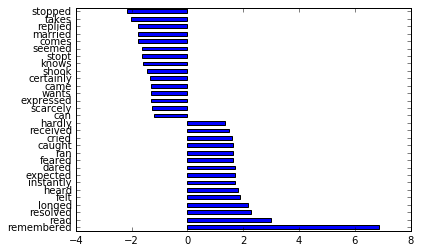

In [24]:
plot_items_austen.logratio.plot.barh()

Plot the results, doing lots of matplotlib fiddling to make it look pretty.

In [25]:
def gender_plot(plot_items, author):
    plt.figure(figsize=(10,10))

    plot_items['colour'] = plot_items.logratio.apply(lambda l: 'r' if l > 0 else 'b')

    plt.plot(plot_items[plot_items.logratio > 0].logratio, 
             plot_items[plot_items.logratio > 0].index_pos, 
             marker='o', linestyle='', markersize=15.0, color='r')

    plt.plot(plot_items[plot_items.logratio < 0].logratio, 
             plot_items[plot_items.logratio < 0].index_pos, 
             marker='o', linestyle='', markersize=15.0, color='b')

    for _, r in plot_items.iterrows():
        plt.plot([0, r.logratio], [r.index_pos, r.index_pos], color=r.colour, linestyle='-', linewidth=3)


    words = plot_items.sort_values('index_pos').index
    plt.yticks(np.arange(len(plot_items)), words)
    plt.ylim([plot_items.index_pos.min() - 1, plot_items.index_pos.max() + 1])
    
    xts = list(range(int(min(plot_items.logratio)) - 1, int(max(plot_items.logratio)) + 2))
    plt.xticks(xts, ['×{}'.format(2**i) for i in xts])
#     plt.xticks([-2, -1, 0, 1, 2, 3, 4, 5, 6], ['×¼', '×½', 'same', '×2', '×4', '×8', '×16', '×32', '×64'])

    plt.tick_params(axis='y', which='major', labelsize=16)
    plt.tick_params(axis='x', which='major', labelsize=12)

    plt.xlabel("Relative appearance after 'she' compared to 'he'", fontsize=16)

    plt.suptitle("Words paired with 'he' and 'she' in {}'s novels".format(author), fontsize=20)
    plt.title(("Women {}, {}, and {} ".format(words[-1], words[-2], words[-3]) + 
              "while men {}, {}, and {}".format(words[0], words[1], words[2])) , fontsize=16)

    plt.grid()

    for spine in plt.gca().spines.values():
        spine.set_visible(False)    

    plt.show()

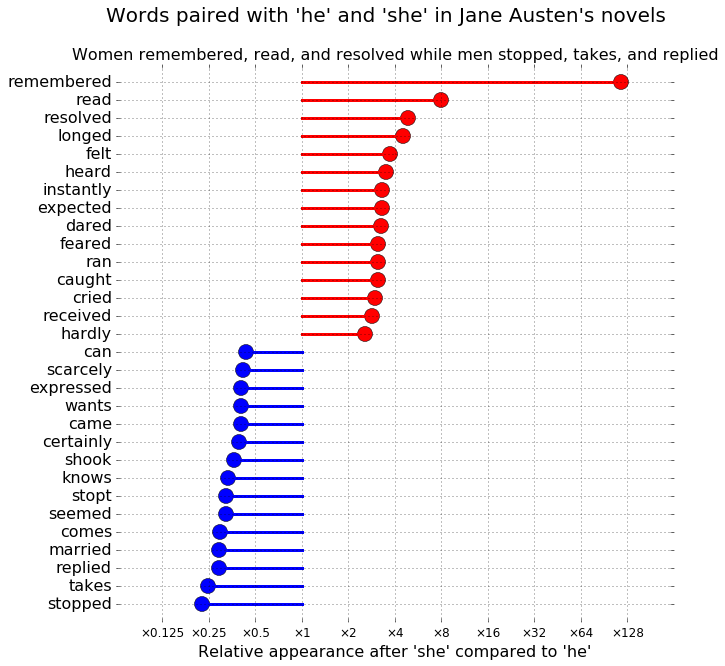

In [26]:
gender_plot(plot_items_austen, 'Jane Austen')

This shows a clear difference. Men take direct, physical action while women are more passive and have more emotions.

# George Eliot
Do the same with the books of George Eliot, another 19th century female novelist, reusing the functions defined above.

In [27]:
eliot_books = {title: open(eliot_books_filenames[title],  
                            encoding='utf-8', errors='replace').read().lower()
                for title in eliot_books_filenames}

In [28]:
eliot_books_all_tokens = [token 
                          for book in eliot_books 
                          for token in tokens(eliot_books[book])]
len(eliot_books_all_tokens)

612175

In [29]:
gendered_bigrams_eliot = gendered_bigrams(eliot_books_all_tokens)
gendered_bigrams_eliot.head(10)

(he, had)       1424
(he, was)       1038
(she, had)       761
(she, was)       705
(he, would)      367
(he, said)       357
(he, could)      283
(she, said)      239
(he, is)         226
(she, would)     209
dtype: int64

In [30]:
useful_gender_counts_eliot = gender_counts(gendered_bigrams_eliot, lower_limit=10) 
useful_gender_counts_eliot.head()

,he,she
added,65,44
always,31,12
and,20,17
answered,22,15
asked,12,8


Testing that we get the same results as with Silge's original post.

In [31]:
gender_ratio_eliot = find_ratios(useful_gender_counts_eliot, smoothing_add=1, smoothing_scale=1)
gender_ratio_eliot.sort_values('abslogratio', ascending=False).head(10)

,he,she,logratio,abslogratio
herself,0.000136,0.005437,5.326106,5.326106
himself,0.003931,0.000227,-4.116838,4.116838
read,0.000542,0.002719,2.326106,2.326106
ran,0.000542,0.002266,2.063071,2.063071
left,0.002982,0.000906,-1.718288,1.718288
means,0.001491,0.000453,-1.718288,1.718288
shall,0.001491,0.000453,-1.718288,1.718288
needed,0.000949,0.002719,1.518751,1.518751
told,0.003117,0.001133,-1.460491,1.460491
married,0.000678,0.001812,1.419215,1.419215


In [32]:
gender_ratio_eliot = find_ratios(useful_gender_counts_eliot)
gender_ratio_eliot.sort_values('abslogratio', ascending=False).head(10)

,he,she,logratio,abslogratio
herself,0.000014,0.005202,8.589442,8.589442
himself,0.003795,0.000023,-7.396733,7.396733
read,0.000419,0.002500,2.577913,2.577913
shall,0.001364,0.000248,-2.461087,2.461087
means,0.001364,0.000248,-2.461087,2.461087
ran,0.000419,0.002049,2.291292,2.291292
left,0.002850,0.000698,-2.029210,2.029210
told,0.002985,0.000923,-1.692657,1.692657
dreaded,0.001499,0.000473,-1.664405,1.664405
needed,0.000824,0.002500,1.601372,1.601372


This is where the stopwords come in useful. Let's exclude the very common phrases 'he himself' and 'her herself', which means "he himself dreaded" is converted to "he dreaded".

In [45]:
eliot_books_all_tokens = [token 
                          for book in eliot_books 
                          for token in tokens(eliot_books[book], stopwords=['himself', 'herself'])]
gendered_bigrams_eliot = gendered_bigrams(eliot_books_all_tokens)
useful_gender_counts_eliot = gender_counts(gendered_bigrams_eliot, lower_limit=10) 
gender_ratio_eliot = find_ratios(useful_gender_counts_eliot)
gender_ratio_eliot.sort_values('abslogratio', ascending=False).head(10)

,he,she,logratio,abslogratio
read,0.000418,0.002502,2.580082,2.580082
shall,0.001363,0.000248,-2.458917,2.458917
means,0.001363,0.000248,-2.458917,2.458917
ran,0.000418,0.002051,2.293461,2.293461
left,0.002847,0.000699,-2.027040,2.027040
dreaded,0.001633,0.000473,-1.786683,1.786683
told,0.002982,0.000924,-1.690488,1.690488
called,0.002173,0.000699,-1.636858,1.636858
needed,0.000823,0.002502,1.603541,1.603541
knows,0.002712,0.000924,-1.553637,1.553637


In [46]:
# eliot_books_all_tokens = [token 
#                           for book in eliot_books 
#                           for token in tokens(eliot_books[book], 
#                                               stopwords=['himself', 'herself',
#                                                         'shall', 'should', 'may', 'might',
#                                                          'will', 'would', 'can', 'could'])]
# gendered_bigrams_eliot = gendered_bigrams(eliot_books_all_tokens)
# useful_gender_counts_eliot = gender_counts(gendered_bigrams_eliot, lower_limit=10) 
# gender_ratio_eliot = find_ratios(useful_gender_counts_eliot)
# gender_ratio_eliot.sort_values('abslogratio', ascending=False).head(10)

In [47]:
plot_items_eliot = extract_plot_items(gender_ratio_eliot, window=15)
len(plot_items_eliot)

30

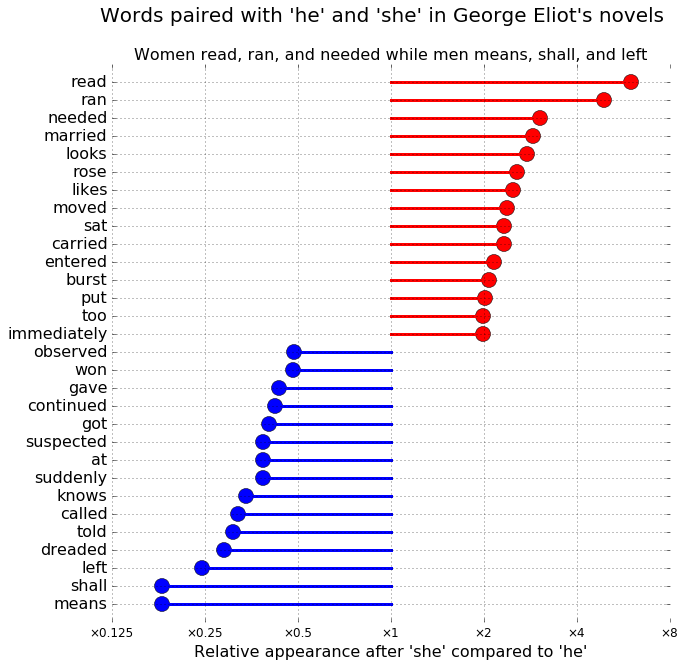

In [48]:
gender_plot(plot_items_eliot, 'George Eliot')

Again, women are associated passive verbs while men are associated with action and speaking.

# Charlotte Brontë's book, _Jane Eyre_
This was called out in the original paper fitting the pattern less well, with women taking more active roles and men having more emotions. Does this pan out?

In [57]:
bronte_books = {title: open(bronte_books_filenames[title],  
                            encoding='utf-8', errors='replace').read().lower()
                for title in bronte_books_filenames}

In [62]:
bronte_books_all_tokens = [token 
                           for book in bronte_books 
                           for token in tokens(bronte_books[book])]
len(bronte_books_all_tokens)

189448

In [63]:
gendered_bigrams_bronte = gendered_bigrams(bronte_books_all_tokens)
gendered_bigrams_bronte[:10]

(he, was)      155
(she, was)     154
(he, had)      132
(she, had)     122
(he, said)      96
(he, is)        88
(he, would)     83
(she, is)       79
(she, said)     57
(he, has)       44
dtype: int64

In [64]:
useful_gender_counts_bronte = gender_counts(gendered_bigrams_bronte, lower_limit=10) 
useful_gender_counts_bronte.head()

,he,she
added,10,6
again,7,9
and,21,11
answered,14,6
asked,31,12


In [65]:
gender_ratio_bronte = find_ratios(useful_gender_counts_bronte, smoothing_add=1, smoothing_scale=1)
gender_ratio_bronte.sort_values('abslogratio', ascending=False).head(10)

,he,she,logratio,abslogratio
shall,0.002629,0.012429,2.241019,2.241019
s,0.004382,0.018079,2.044621,2.044621
paused,0.011394,0.004520,-1.333890,1.333890
made,0.007888,0.019209,1.284087,1.284087
stood,0.013146,0.005650,-1.218413,1.218413
asked,0.028046,0.014689,-0.933011,0.933011
were,0.006135,0.011299,0.881123,0.881123
can,0.007011,0.012429,0.825981,0.825981
spoke,0.007888,0.004520,-0.803376,0.803376
took,0.017528,0.010169,-0.785454,0.785454


In [66]:
gender_ratio_bronte = find_ratios(useful_gender_counts_bronte)
gender_ratio_bronte.sort_values('abslogratio', ascending=False).head(10)

,he,she,logratio,abslogratio
shall,0.001826,0.011298,2.629181,2.629181
s,0.003565,0.016890,2.244140,2.244140
paused,0.010522,0.003468,-1.601380,1.601380
stood,0.012261,0.004586,-1.418712,1.418712
made,0.007043,0.018009,1.354354,1.354354
spoke,0.007043,0.003468,-1.022367,1.022367
asked,0.027043,0.013535,-0.998620,0.998620
were,0.005304,0.010179,0.940344,0.940344
saw,0.008783,0.004586,-0.937372,0.937372
took,0.016609,0.009060,-0.874292,0.874292


In [67]:
plot_items_bronte = extract_plot_items(gender_ratio_bronte, window=15)
len(plot_items_bronte)

30

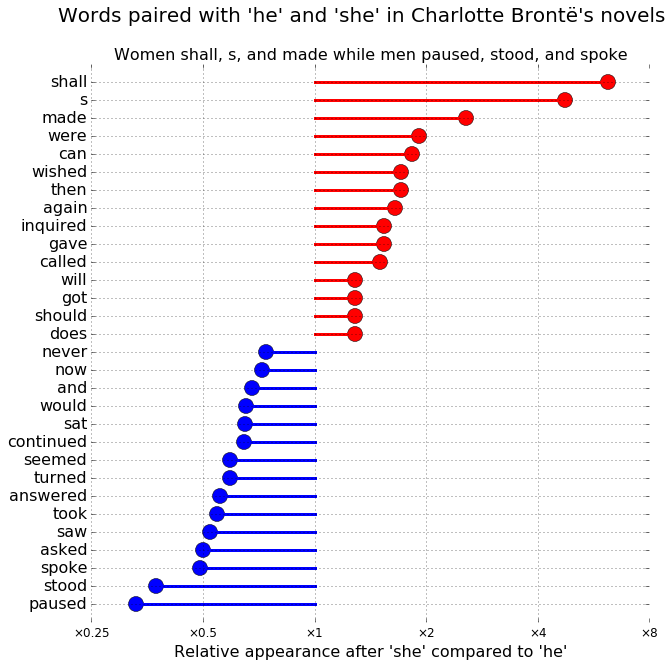

In [68]:
gender_plot(plot_items_bronte, 'Charlotte Brontë')

Yes, many of the verbs after 'she' are not related to emotions, while men are more passive, standing and pausing.

's' is an interesting token. It appears in direct speech, as "she's …" and, rarely, "he's …", so is an abbreviation of "is", which isn't reported as having gendered usage. Quite why women are referred to in this way in speech is something for another investigation.

# Now with Oscar Wilde's book, _The Picture of Dorian Grey_

Not in Silge's article, but in the original paper, _The Picture of Dorian Grey_ was called out as another gender-swap, with women being active and men being emotional.

In [75]:
wilde_books = {title: open(wilde_books_filenames[title],  
                            encoding='utf-8', errors='replace').read().lower()
                for title in wilde_books_filenames}

In [76]:
wilde_books_all_tokens = [token 
                           for book in wilde_books 
                           for token in tokens(wilde_books[book])]
len(wilde_books_all_tokens)

80416

In [77]:
gendered_bigrams_wilde = gendered_bigrams(wilde_books_all_tokens)
gendered_bigrams_wilde[:10]

(he, had)         215
(he, was)         161
(he, is)           61
(he, would)        61
(he, said)         46
(he, felt)         44
(she, was)         41
(she, is)          40
(she, had)         39
(he, answered)     33
dtype: int64

In [78]:
useful_gender_counts_wilde = gender_counts(gendered_bigrams_wilde, lower_limit=10) 
useful_gender_counts_wilde.head()

,he,she
answered,33,10
asked,16,4
could,31,5
cried,23,15
did,17,6


In [81]:
gender_ratio_wilde = find_ratios(useful_gender_counts_wilde)
gender_ratio_wilde.sort_values('abslogratio', ascending=False).head(10)

,he,she,logratio,abslogratio
laughed,0.004331,0.027245,2.653113,2.653113
will,0.008557,0.046431,2.439931,2.439931
turned,0.022290,0.004221,-2.400750,2.400750
saw,0.017008,0.004221,-2.010567,2.010567
thought,0.014895,0.004221,-1.819202,1.819202
remembered,0.014895,0.004221,-1.819202,1.819202
got,0.013839,0.004221,-1.713074,1.713074
went,0.022290,0.008058,-1.467864,1.467864
is,0.064547,0.153876,1.253348,1.253348
cried,0.024403,0.057943,1.247574,1.247574


In [82]:
plot_items_wilde = extract_plot_items(gender_ratio_wilde, window=15)
len(plot_items_wilde)

30

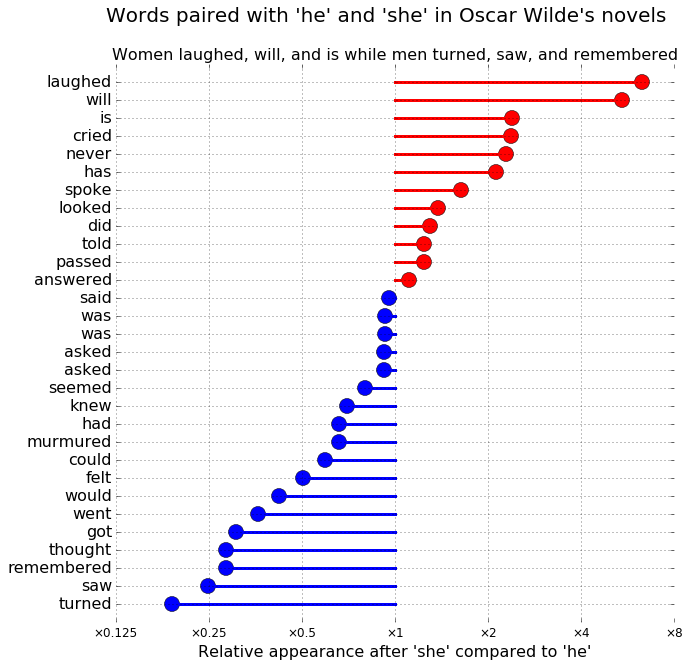

In [84]:
gender_plot(plot_items_wilde, 'Oscar Wilde')

Yes, the men have the typically emotion-related verbs such as 'remember' and 'think', while women lauch and cry (which could be "cry out" so much as sob).

# Charles Dickens's books
A typically male 19th century author, with many books with male protagonists.

In [88]:
dickens_books = {title: open(dickens_books_filenames[title],  
                            encoding='utf-8', errors='replace').read().lower()
                for title in dickens_books_filenames}

In [90]:
dickens_books_all_tokens = [token 
                           for book in dickens_books 
                           for token in tokens(dickens_books[book])]
len(dickens_books_all_tokens)

756590

In [91]:
gendered_bigrams_dickens = gendered_bigrams(dickens_books_all_tokens)
gendered_bigrams_dickens[:10]

(he, had)       937
(he, was)       895
(she, was)      619
(she, had)      490
(he, said)      376
(he, would)     296
(he, is)        291
(she, said)     188
(she, would)    182
(he, could)     165
dtype: int64

In [92]:
useful_gender_counts_dickens = gender_counts(gendered_bigrams_dickens, lower_limit=10) 
useful_gender_counts_dickens.head()

,he,she
added,33,12
ain,4,8
always,25,23
and,45,29
answered,37,44


In [93]:
gender_ratio_dickens = find_ratios(useful_gender_counts_dickens)
gender_ratio_dickens.sort_values('abslogratio', ascending=False).head(10)

,he,she,logratio,abslogratio
explained,0.001803,0.000276,-2.709410,2.709410
ate,0.001505,0.000276,-2.448758,2.448758
certainly,0.001505,0.000276,-2.448758,2.448758
cried,0.001207,0.005538,2.198074,2.198074
rejoined,0.002250,0.000526,-2.096066,2.096066
ran,0.000909,0.003283,1.852707,1.852707
resumed,0.002697,0.000777,-1.795628,1.795628
carried,0.001803,0.000526,-1.776524,1.776524
be,0.000760,0.002531,1.735808,1.735808
ain,0.000611,0.002030,1.732320,1.732320


In [94]:
plot_items_dickens = extract_plot_items(gender_ratio_dickens, window=15)
len(plot_items_dickens)

30

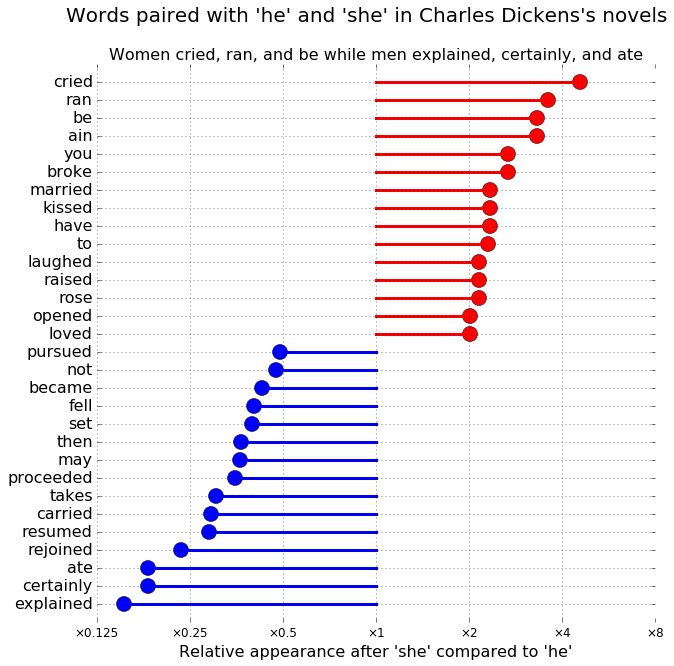

In [95]:
gender_plot(plot_items_dickens, 'Charles Dickens')

Women cry and run, while men explain and are certain. Very stereotypical genered behaviour.